# Generalized Linear Models (GLMs) in Regression

**Generalized Linear Models (GLMs)** extend traditional linear models to allow for response variables that have error distribution models other than a normal distribution.

GLMs are widely used when:
- The target variable does **not** follow a normal distribution (e.g., binomial, Poisson, Gamma).
- You want to apply a transformation (link function) to the target variable.

### Basic Structure of GLMs

A GLM has three components:
1. **Random component**: Distribution of the response variable (e.g., Normal, Poisson, Binomial)
2. **Systematic component**: Linear combination of predictors (e.g., `Xβ`)
3. **Link function**: Function that connects the mean of the distribution to the linear predictors

Mathematically:

$$g( E[Y|X] ) = Xβ$$

Where `g()` is the **link function**.

In this tutorial, we will:
- Explore GLMs using scikit-learn and statsmodels
- Use different families: Gaussian, Poisson
- Compare GLMs to traditional linear regression



In [1]:
# Importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# For models
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# For GLMs
from sklearn.linear_model import LinearRegression, PoissonRegressor, TweedieRegressor
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')

# Set aesthetic plots
sns.set(style="whitegrid")


In [2]:
# Load dataset from sklearn
data = fetch_california_housing()
df = pd.DataFrame(data.data, columns=data.feature_names)
df['Target'] = data.target

# Show top rows
df.head()


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,Target
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   MedInc      20640 non-null  float64
 1   HouseAge    20640 non-null  float64
 2   AveRooms    20640 non-null  float64
 3   AveBedrms   20640 non-null  float64
 4   Population  20640 non-null  float64
 5   AveOccup    20640 non-null  float64
 6   Latitude    20640 non-null  float64
 7   Longitude   20640 non-null  float64
 8   Target      20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


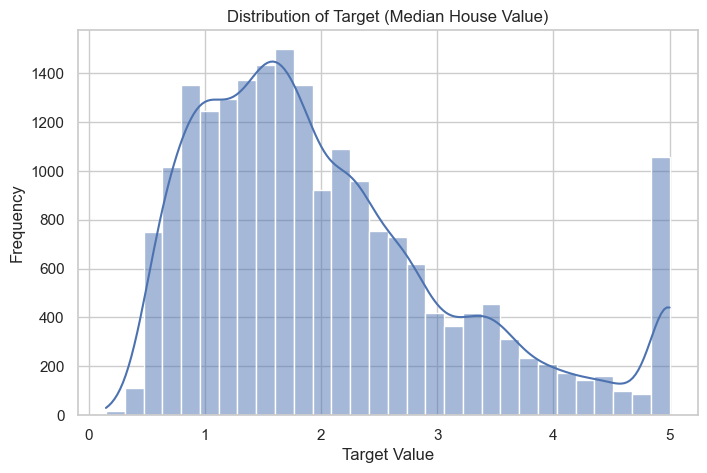

In [3]:
# Check data info
df.info()

# Distribution of the target variable
plt.figure(figsize=(8, 5))
sns.histplot(df['Target'], kde=True, bins=30)
plt.title("Distribution of Target (Median House Value)")
plt.xlabel("Target Value")
plt.ylabel("Frequency")
plt.show()


The target variable (median house value in $100,000s) seems **right-skewed**, which might violate the assumptions of OLS regression (which assumes normality of residuals).

This makes it a good candidate to explore GLMs with different distributions (e.g., Tweedie, Poisson).


In [4]:
# Split into train and test sets
X = df.drop('Target', axis=1)
y = df['Target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features for better convergence
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [5]:
# Fit a standard linear regression
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

print(f"Linear Regression R^2 Score: {lr.score(X_test_scaled, y_test):.4f}")


Linear Regression R^2 Score: 0.5758


Poisson Regression ( Count Data )

In [6]:
# Poisson regression assumes the target is count-like and positive
poisson = PoissonRegressor(alpha=0.0, max_iter=1000)
poisson.fit(X_train_scaled, y_train)

print(f"Poisson GLM R^2 Score: {poisson.score(X_test_scaled, y_test):.4f}")


Poisson GLM R^2 Score: 0.5507


> **Note**: Poisson regression assumes the target variable is count data. Though house values are continuous, we use it here to demonstrate Poisson GLM behavior.


The **Tweedie family** is a flexible GLM model that covers several distributions:

- Power = 0: Normal (Linear Regression)
- Power = 1: Poisson
- Power ∈ (1, 2): Compound Poisson-Gamma (useful for continuous positive data)
- Power = 2: Gamma
- Power = 3: Inverse Gaussian


In [8]:

for power_value in [0, 1, 1.5, 2, 3]:
    tweedie = TweedieRegressor(power=power_value, alpha=0.5, link='log', max_iter=1000)
    tweedie.fit(X_train_scaled, y_train)
    print(f"Tweedie GLM for power = {power_value}, R^2 Score: {tweedie.score(X_test_scaled, y_test):.4f}")


Tweedie GLM for power = 0, R^2 Score: 0.4875
Tweedie GLM for power = 1, R^2 Score: 0.4762
Tweedie GLM for power = 1.5, R^2 Score: 0.4537
Tweedie GLM for power = 2, R^2 Score: 0.4114
Tweedie GLM for power = 3, R^2 Score: 0.2850


In [10]:
tweedie = TweedieRegressor(power=1, alpha=0.5, link='log', max_iter=1000)
tweedie.fit(X_train_scaled, y_train)
print(f"Tweedie GLM R^2 Score: {tweedie.score(X_test_scaled, y_test):.4f}")

Tweedie GLM R^2 Score: 0.4762


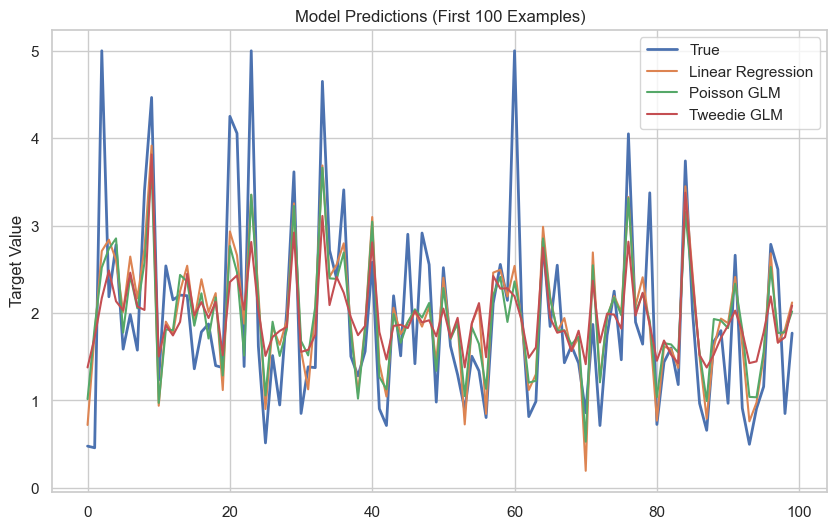

In [11]:
# Predict with all models
y_pred_lr = lr.predict(X_test_scaled)
y_pred_poisson = poisson.predict(X_test_scaled)
y_pred_tweedie = tweedie.predict(X_test_scaled)

# Plot comparison
plt.figure(figsize=(10, 6))
plt.plot(y_test.values[:100], label='True', linewidth=2)
plt.plot(y_pred_lr[:100], label='Linear Regression')
plt.plot(y_pred_poisson[:100], label='Poisson GLM')
plt.plot(y_pred_tweedie[:100], label='Tweedie GLM')
plt.legend()
plt.title("Model Predictions (First 100 Examples)")
plt.ylabel("Target Value")
plt.show()


In [13]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def model_metrics(y_true, y_pred, model_name):
    print(f"{model_name}")
    print(f"R^2 Score: {r2_score(y_true, y_pred):.4f}")
    print(f"MSE: {mean_squared_error(y_true, y_pred):.4f}")
    print(f"MAE: {mean_absolute_error(y_true, y_pred):.4f}")
    print('-' * 30)

model_metrics(y_test, y_pred_lr, "Linear Regression")
model_metrics(y_test, y_pred_poisson, "Poisson GLM")
model_metrics(y_test, y_pred_tweedie, "Tweedie GLM")


Linear Regression
R^2 Score: 0.5758
MSE: 0.5559
MAE: 0.5332
------------------------------
Poisson GLM
R^2 Score: 0.0399
MSE: 1.2581
MAE: 0.5541
------------------------------
Tweedie GLM
R^2 Score: 0.4541
MSE: 0.7153
MAE: 0.6242
------------------------------


# When Should You Use GLMs Instead of Linear Regression?

- Use **Linear Regression** when:
  - The target is continuous and normally distributed
  - Residuals are homoscedastic

- Use **GLMs** when:
  - The target has a skewed or non-normal distribution
  - You need to model count, binary, or strictly positive continuous data
  - You want to explicitly choose a **link function** to control the relationship

### Common GLMs:
| Model Type        | Distribution | Link Function   | Use Case                  |
|------------------|--------------|-----------------|---------------------------|
| Linear Regression| Normal       | Identity        | General purpose           |
| Logistic         | Binomial     | Logit           | Binary classification     |
| Poisson          | Poisson      | Log              | Count data                |
| Gamma            | Gamma        | Inverse         | Positive skewed data      |
| Tweedie          | Tweedie      | Log              | Positive continuous w/ zeros |
